# Yoga Poses Classifier

Image classification model for yoga poses based on transfer learning techniques.

Algorithm:

* Identify coordinates of 17 keypoints in the image using pretrained model    
* Produce new features based on distance between keypoints and their relative positions
* Train densely connected neural network on keypoint coordinates and position features
   
To account for small number of images and class imbalance training is performed on original images and then repeated on original flipped images.

Pretrained models:

* https://tfhub.dev/google/movenet/singlepose/thunder/3 - larger model for higher accuracy
* https://tfhub.dev/google/movenet/singlepose/lightning/3 - smaller model for faster inference
    
Pretrained model inputs: frame of video or an image represented as an int32 tensor of shape:
    - 256 x 256 x 3 for larger model("Thunder")
    - 192 x 192 x 3 for smaller model ("Lightning")

Channels order: RGB with values in range 0-255.

Outputs: float32 tensor of shape (1, 1, 17, 3).

The first two channels of the last dimension represents the y and x coordinates normalized to image frame, i.e. range in (0.0, 1.0) of the 17 keypoints in the order of: nose, left eye, right eye, left ear, right ear, left shoulder, right shoulder, left elbow, right elbow, left wrist, right wrist, left hip, right hip, left knee, right knee, left ankle, right ankle. 

The third channel of the last dimension represents the prediction confidence scored of each keypoint, also in the range (0.0, 1.0).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from itertools import combinations
import glob

import concurrent.futures
from tqdm import tqdm
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Settings

In [ ]:
# Plots display settings
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams.update({'font.size': 14})

# Model paths: single person pose classification
model_path = 'https://tfhub.dev/google/movenet/singlepose/thunder/3'  # Larger version
model_path_light = 'https://tfhub.dev/google/movenet/singlepose/lightning/3'  # Lighter version

# Directory containing 107 subfolders with images
data_directory_path = '/content/drive/MyDrive/Human Pose Estimation/dataset'

# TensorFlow settings
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMG_SIZE = 256
IMG_SIZE_LIGHT = 192
BATCH_SIZE = 32

In [ ]:
# 17 keypoints in the model output
kp_descriptions = [
    'nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear',
    'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow',
    'left_wrist', 'right_wrist', 'left_hip', 'right_hip',
    'left_knee', 'right_knee', 'left_ankle', 'right_ankle'
]

## Functions

In [ ]:
def get_image(path: str, flip=False) -> tf.Tensor:
    """Function loads image from a file and resizes it.
    :param path: Path to image file
    :param flip: Optional argument indicating whether to flip the image left to right
    :return: Tensor with resized image data
    """
    image = tf.expand_dims(tf.compat.v1.image.decode_jpeg(
        tf.io.read_file(path), channels=3), axis=0)
    if flip:
        image = tf.image.flip_left_right(image)
    # Resize and pad the image to keep the aspect ratio and fit the expected size
    image = tf.cast(tf.image.resize_with_pad(image, IMG_SIZE_LIGHT, IMG_SIZE_LIGHT), dtype=tf.int32)
    return image


def configure_for_performance(ds: tf.data.Dataset) -> tf.data.Dataset:
    """Function applies batch() and prefetch() functions
    to the dataset to optimize data processing.
    :param ds: TensorFlow Dataset object
    :return Batched TensorFlow Dataset object
    """
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE).cache()
    return ds


def movenet_inference(model: tf.keras.Model, path: str, flip=False) -> tf.Tensor:
    """Function transforms an image to a tensor of shape [1, 17, 3]
    containing y and x coordinates and confidence level for 17 keypoints.
    :param model: movenet model in tensorflow format
    :param path: Path to image file
    :param flip: Optional argument indicating whether to flip the image left to right
    :return: Tensor with data for 17 keypoints
    """
    keypoints = model.inference_fn(get_image(path, flip))[0]
    return keypoints


def movenet_inference_flat(model: tf.keras.Model, path: str, flip=False) -> np.array:
    """Function transforms an image to a numpy array shape [51,]
    containing y and x coordinates and confidence level for 17 keypoints.
    :param model: movenet model in tensorflow format
    :param path: Path to image file
    :param flip: Optional argument indicating whether to flip the image left to right
    :return: 1D array with 51 values
    """
    keypoints = model.inference_fn(get_image(path, flip))[0][0].numpy().flatten()
    return keypoints


def movenet_serving(model: tf.keras.Model, path: str, flip=False) -> tf.Tensor:
    """Function transforms an image to a tensor of shape [1, 17, 3]
    containing y and x coordinates and confidence level for 17 keypoints.
    :param model: Movenet model in tensorflow format
    :param path: Path to image file
    :param flip: Optional argument indicating whether to flip the image left to right
    :return: Tensor with data for 17 keypoints
    """
    keypoints = model(get_image(path, flip))['output_0'][0]
    return keypoints


def movenet_serving_flat(model: tf.keras.Model, path: str, flip=False) -> np.array:
    """Function transforms an image to a numpy array shape [51,]
    containing y and x coordinates and confidence level for 17 keypoints.
    :param model: Movenet model in tensorflow format
    :param path: Path to image file
    :param flip: Optional argument indicating whether to flip the image left to right
    :return: 1D array with 51 values
    """
    keypoints = model(get_image(path, flip))['output_0'][0][0].numpy().flatten()
    return keypoints


def display_images():
    """Function displays 100 examples of images
    belonging to different classes in 5 x 5 grids.
    """
    nrows = ncols = 5
    class_n = 0

    for pose in classes_df['pose'].unique():

        if class_n > 100:
            break

        class_n += 1

        if class_n % 25 == 1:
            fig = plt.gcf()
            fig.set_size_inches(ncols * 2.7, nrows * 2.7)

        image_path = classes_df[classes_df['pose'] == pose]['path'].iloc[0]
        image = mpimg.imread(image_path)
        plt.subplot(nrows, ncols, class_n % 25 + 1)
        plt.imshow(image)
        plt.axis('Off')
        plt.title(pose)

        if class_n % 25 == 1 and class_n != 1:
            plt.show()


def display_keypoints(path: str, points: tf.Tensor):
    """Function displays an image with marked keypoints.
    :param path: Path to the image file
    :param points: Tensor of keypoints in the shapes of [17, 3],
    where 0-th column contains y coordinates, 1st column - x coordinates,
    2nd column - confidence score
    """
    # Convert coordinates from range [0, 1] to absolute positions
    y = points[:, 0] * IMG_SIZE_LIGHT
    x = points[:, 1] * IMG_SIZE_LIGHT

    # Read image from file and resize with padding
    image = tf.compat.v1.image.decode_jpeg(tf.io.read_file(path), channels=3)
    image = tf.image.resize_with_pad(image, IMG_SIZE_LIGHT, IMG_SIZE_LIGHT)
    image = tf.cast(image, dtype=tf.uint8)

    plt.imshow(image)
    plt.scatter(x, y)
    plt.axis('Off')
    plt.show()


def distance(coordinates: np.array) -> tuple:
    """Function calculates distance between two keypoints
    described by x and y coordinates relative to image size.
    :param coordinates: Array with 4 values [x coordinate of the 1st keypoint,
    y coordinate of the 1st keypoint, x coordinate of the 2nd keypoint,
    y coordinate of the 2nd keypoint]
    :return: Tuple with 3 values [Euclidean distance between two points,
    distance between x coordinates, distance between y coordinates]
    """
    x_1, y_1, x_2, y_2 = coordinates
    hor_dist = abs(x_1 - x_2)
    vert_dist = abs(y_1 - y_2)
    dist = np.sqrt(hor_dist ** 2 + vert_dist ** 2)
    return dist, hor_dist, vert_dist


def is_higher(coordinates: np.array) -> int:
    """Function identifies relative positions
    of two y coordinates in vertical direction.
    :param coordinates: Array with 2 values [y coordinate of the 1st keypoint,
    y coordinate of the 2nd keypoint]
    :return: Binary value (1 - if the 1st coordinate is higher than 2nd,
    0 - if the 1st coordinate is lower than 2nd coordinate)
    """
    y_1, y_2 = coordinates
    res = int((y_1 - y_2) > 0)
    return res


def add_pos_features(df: pd.DataFrame, drop_scores=False) -> pd.DataFrame:
    """Function creates positional features based on keypoints.
    :param df: DataFrame with keypoints (x and y coordinates)
    :param drop_scores: Optional argument specifying whether to drop confidence scores
    :return: Updated DataFrame
    """
    # Distance between left and right points in pairs of limbs
    # relative to image size (Euclidean, horizontal and vertical)
    for point_type in ('elbow', 'wrist', 'knee', 'ankle'):
        d = np.apply_along_axis(
            distance, 1, df[[
                f'left_{point_type}_x', f'left_{point_type}_y',
                f'right_{point_type}_x', f'right_{point_type}_y'
            ]].values)
        df[f'{point_type}s_dist'], df[f'{point_type}s_hor_dist'], \
        df[f'{point_type}s_vert_dist'] = d.transpose()

    # Distance between specific keypoint pairs
    for point_1, point_2 in [('wrist', 'ankle'), ('wrist', 'knee'),
                             ('wrist', 'hip'), ('wrist', 'elbow'),
                             ('wrist', 'shoulder'), ('wrist', 'ear'),
                             ('ankle', 'hip'), ('ankle', 'ear'),
                             ('elbow', 'knee'), ('knee', 'hip')]:
        for side_1 in ('left', 'right'):
            for side_2 in ('left', 'right'):
                d = np.apply_along_axis(
                    distance, 1, df[[
                        f'{side_1}_{point_1}_x', f'{side_1}_{point_1}_y',
                        f'{side_2}_{point_2}_x', f'{side_2}_{point_2}_y'
                    ]].values)
                df[f'{side_1}_{point_1}_{side_2}_{point_2}_dist'], \
                df[f'{side_1}_{point_1}_{side_2}_{point_2}_hor_dist'], \
                df[f'{side_1}_{point_1}_{side_2}_{point_2}_vert_dist'] = d.transpose()

    # Relative upper / lower positions of specific keypoints (binary values: 0/1)
    for point_1, point_2 in combinations(['ear', 'hip', 'knee', 'ankle', 'wrist', 'elbow'], 2):
        for side_1 in ('left', 'right'):
            for side_2 in ('left', 'right'):
                df[f'{side_1}_{point_1}_{side_2}_{point_2}'] = np.apply_along_axis(
                    is_higher, 1, df[[
                        f'{side_1}_{point_1}_y', f'{side_2}_{point_2}_y'
                    ]].values)

    if drop_scores:
        columns = filter(lambda x: x.find('score') == -1, df.columns)
        df = df[columns]

    print('Positional features added. DataFrame shape:', df.shape)

    return df


def get_model(n_features: int, n_classes, dense_neurons: list) -> tf.keras.Model:
    """Function creates a Densely Connected Neural Network.
    :param n_features: Number of input features
    :param n_classes: Number of classes
    :param dense_neurons: List contains number of neurons in dense layers
    :return: Compiled tensorflow model
    """
    model = tf.keras.Sequential(
        [tf.keras.layers.Input(shape=(n_features,))]
    )

    for n_neurons in dense_neurons:
        model.add(tf.keras.layers.Dense(
            n_neurons, activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(0.001))
        )

    model.add(tf.keras.layers.Dense(n_classes, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    model.summary()

    return model


def train_model(model: tf.keras.Model,
                train_ds: tf.data.Dataset,
                val_ds: tf.data.Dataset) -> tf.keras.Model:
    """Function trains the model and evaluates it's performance,
    displays training metrics.
    :param model: Untrained model
    :param train_ds: Training Dataset containing input data and labels
    :param val_ds: Validation Dataset containing input data and labels
    :return: Trained model
    """
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=5,
                                                  restore_best_weights=True)

    history = model.fit(train_ds, validation_data=val_ds,
                        epochs=100, verbose=2, callbacks=[early_stop],
                        use_multiprocessing=True, workers=-1)

    loss, acc = model.evaluate(valid_ds)
    print(f'Validation loss: {loss}\nValidation accuracy: {acc}')
    plot_history(history)

    return model


def plot_history(hist):
    """Function plots a chart with training and validation metrics.
    :param hist: Tensorflow history object from model.fit()
    """
    # Losses and metrics
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    acc = hist.history['sparse_categorical_accuracy']
    val_acc = hist.history['val_sparse_categorical_accuracy']

    # Epochs to plot along x axis
    x_axis = range(1, len(loss) + 1)

    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

    ax1.plot(x_axis, loss, 'bo', label='Training')
    ax1.plot(x_axis, val_loss, 'ro', label='Validation')
    ax1.set_title('Categorical crossentropy')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(x_axis, acc, 'bo', label='Training')
    ax2.plot(x_axis, val_acc, 'ro', label='Validation')
    ax2.set_title('Categorical accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

## Exploratory Data Analysis

DataFrame shape: (6002, 3)
                                                path          pose  label
0  /content/drive/MyDrive/Human Pose Estimation/d...  tittibhasana     81
1  /content/drive/MyDrive/Human Pose Estimation/d...  tittibhasana     81
2  /content/drive/MyDrive/Human Pose Estimation/d...  tittibhasana     81
3  /content/drive/MyDrive/Human Pose Estimation/d...  tittibhasana     81
4  /content/drive/MyDrive/Human Pose Estimation/d...  tittibhasana     81


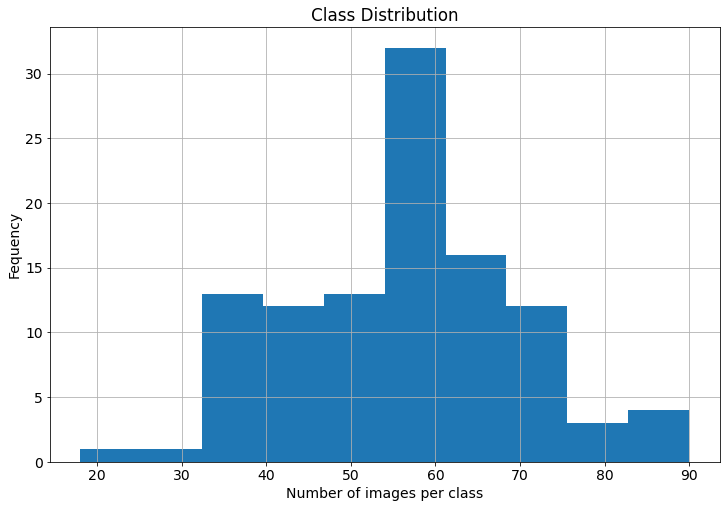

In [ ]:
# Create a DataFrame with 3 columns: image path, class name and class label
image_paths = glob.glob(f'{data_directory_path}/*/*.*')
classes_df = pd.DataFrame({'path': list(image_paths)})
classes_df['pose'] = classes_df['path'].apply(lambda x: x.split('/')[-2])
classes_df['label'] = LabelEncoder().fit_transform(classes_df['pose'])
print(f'DataFrame shape: {classes_df.shape}')
print(classes_df.head())

# Balance of classes
balance = classes_df['pose'].value_counts()
balance.hist(bins=10)
plt.xlabel('Number of images per class')
plt.ylabel('Fequency')
plt.title('Class Distribution')
plt.show()

Original data contains about 6,000 images belonging to 107 classes. Number of images varies from 18 examples to 90 examples per class. Large number of classes and limited number of images does not allow training neural network from scratch. In this case transfer learning would be optimal approach: we need to find ready-to-use model that was trained for a similar task and tune it for the task at hand.

In [ ]:
# Display examples of images
display_images()

Output hidden; open in https://colab.research.google.com to view.

## Pretrained model inference

We will use pretrained model from Tensorflow Hub for feature extraction. For each image the model identifies location of 17 keypoints of a human body relative to the frame of the image (or video). The model was trained on images with only one person moving or standing. Most of the photos in the yoga pose data set are also single person images.

Model is available in two versions:
* "Thunder" version is described as more accurate but slower model
* "Lightning" version is smaller in size and faster for inference

In [ ]:
# Pretrained model for pose classification
hub_model = hub.load(model_path_light)
movenet = hub_model.signatures['serving_default']

In [ ]:
# Model inference for a single image
example_path = classes_df['path'][0]
example_image = get_image(example_path)
outputs = movenet(example_image)
print(outputs)

{'output_0': <tf.Tensor: shape=(1, 1, 17, 3), dtype=float32, numpy=
array([[[[0.30172408, 0.47382474, 0.60786164],
         [0.27075624, 0.5107128 , 0.84134495],
         [0.270653  , 0.4491715 , 0.8296014 ],
         [0.29018667, 0.5712416 , 0.7021016 ],
         [0.2933273 , 0.42904496, 0.6896193 ],
         [0.47742093, 0.6520154 , 0.70820415],
         [0.4546612 , 0.3404466 , 0.7785692 ],
         [0.72302693, 0.6629424 , 0.76916087],
         [0.6915104 , 0.3180951 , 0.60393405],
         [0.9406683 , 0.68821645, 0.73270726],
         [0.9221532 , 0.34429651, 0.7962831 ],
         [0.8181176 , 0.62666166, 0.49770898],
         [0.8188975 , 0.44248623, 0.624044  ],
         [0.4873585 , 0.7488393 , 0.5872404 ],
         [0.5380987 , 0.3584957 , 0.23094091],
         [0.5013628 , 0.746772  , 0.07915336],
         [0.56773365, 0.65401435, 0.04198644]]]], dtype=float32)>}


In [ ]:
# Ouput is a dictionary with [1, 1, 17, 3] tensor.
# For each image the model extracts 17 keypoints: y and x coordinates and confidence level.
keypoints = outputs['output_0']
print(keypoints)

tf.Tensor(
[[[[0.30172408 0.47382474 0.60786164]
   [0.27075624 0.5107128  0.84134495]
   [0.270653   0.4491715  0.8296014 ]
   [0.29018667 0.5712416  0.7021016 ]
   [0.2933273  0.42904496 0.6896193 ]
   [0.47742093 0.6520154  0.70820415]
   [0.4546612  0.3404466  0.7785692 ]
   [0.72302693 0.6629424  0.76916087]
   [0.6915104  0.3180951  0.60393405]
   [0.9406683  0.68821645 0.73270726]
   [0.9221532  0.34429651 0.7962831 ]
   [0.8181176  0.62666166 0.49770898]
   [0.8188975  0.44248623 0.624044  ]
   [0.4873585  0.7488393  0.5872404 ]
   [0.5380987  0.3584957  0.23094091]
   [0.5013628  0.746772   0.07915336]
   [0.56773365 0.65401435 0.04198644]]]], shape=(1, 1, 17, 3), dtype=float32)


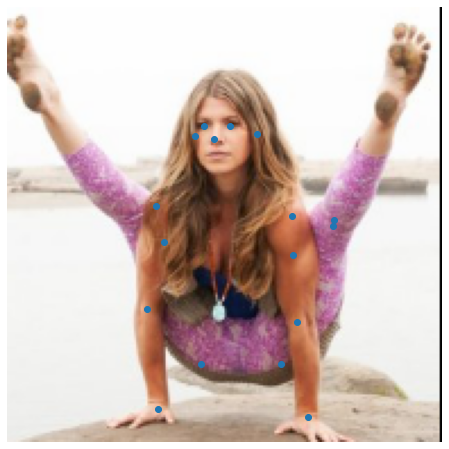

In [ ]:
# Display keypoints superimposed on the image
display_keypoints(path=example_path, points=keypoints[0][0])

In [ ]:
# The same result can be achieved using inference_fn()
print(hub_model.inference_fn(example_image))

tf.Tensor(
[[[[0.30172408 0.47382474 0.60786164]
   [0.27075624 0.5107128  0.84134495]
   [0.270653   0.4491715  0.8296014 ]
   [0.29018667 0.5712416  0.7021016 ]
   [0.2933273  0.42904496 0.6896193 ]
   [0.47742093 0.6520154  0.70820415]
   [0.4546612  0.3404466  0.7785692 ]
   [0.72302693 0.6629424  0.76916087]
   [0.6915104  0.3180951  0.60393405]
   [0.9406683  0.68821645 0.73270726]
   [0.9221532  0.34429651 0.7962831 ]
   [0.8181176  0.62666166 0.49770898]
   [0.8188975  0.44248623 0.624044  ]
   [0.4873585  0.7488393  0.5872404 ]
   [0.5380987  0.3584957  0.23094091]
   [0.5013628  0.746772   0.07915336]
   [0.56773365 0.65401435 0.04198644]]]], shape=(1, 1, 17, 3), dtype=float32)


In [ ]:
# We can convert model output into a 1D array with 51 columns
# representing triplets of values: x, y, confidence
print(hub_model.inference_fn(example_image)[0][0].numpy().flatten())

[0.30172408 0.47382474 0.60786164 0.27075624 0.5107128  0.84134495
 0.270653   0.4491715  0.8296014  0.29018667 0.5712416  0.7021016
 0.2933273  0.42904496 0.6896193  0.47742093 0.6520154  0.70820415
 0.4546612  0.3404466  0.7785692  0.72302693 0.6629424  0.76916087
 0.6915104  0.3180951  0.60393405 0.9406683  0.68821645 0.73270726
 0.9221532  0.34429651 0.7962831  0.8181176  0.62666166 0.49770898
 0.8188975  0.44248623 0.624044   0.4873585  0.7488393  0.5872404
 0.5380987  0.3584957  0.23094091 0.5013628  0.746772   0.07915336
 0.56773365 0.65401435 0.04198644]


We have about 6,000 images in the data set. Converting all the images into keypoint tensors could take considerable time. Developers claim that the inference capacity of "Lightning" version is >50FPS. We will check actual speed of inference using default serving method and inference_fn() and also use multiprocessing.

In [ ]:
# Inference time for 50 images using inference_fn() and multiprocessing
start = time.perf_counter()
keypoints = []

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = [executor.submit(movenet_inference_flat, hub_model, path) for path in classes_df['path'].head(50)]
    for f in tqdm(concurrent.futures.as_completed(results)):
        keypoints.append(f.result())

finish = time.perf_counter()
print(f'Finished in {round(finish - start, 2)} second(s).')

50it [00:01, 35.88it/s]

Finished in 1.53 second(s).


In [ ]:
# Inference time for 50 images using default serving method and multiprocessing
start = time.perf_counter()
keypoints = []

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = [executor.submit(movenet_serving_flat, movenet, path) for path in classes_df['path'].head(50)]
    for f in tqdm(concurrent.futures.as_completed(results)):
        keypoints.append(f.result())

finish = time.perf_counter()
print(f'Finished in {round(finish - start, 2)} second(s).')

50it [00:01, 34.64it/s]

Finished in 1.54 second(s).


In [ ]:
# Inference time for 50 images processed consecutively
start = time.perf_counter()
keypoints = []

for path in tqdm(classes_df['path'].head(50)):
    img = movenet_inference_flat(hub_model, path)
    keypoints.append(img)

finish = time.perf_counter()
print(f'Finished in {round(finish - start, 2)} second(s).')

100%|██████████| 50/50 [00:01<00:00, 26.77it/s]

Finished in 1.87 second(s).


Multiprocessing makes inference faster than processing every single image consecutively. Default serving and inference_fn() demonstrate almost identical speed and depending on the run one or another could be slightly faster. We will use inference_fn() for out purpose.

## Creating Datasets
We create 2 sets of train and validation data:
* Datasets based on original images(highly imbalanced classes)
* Datasets based on original images and images flipped left to right

In [ ]:
# Convert all images into keypoints tensors of shape [51,] and create a list
start = time.perf_counter()
keypoints = []

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = [executor.submit(movenet_inference_flat, hub_model, path) for path in classes_df['path']]
    for f in tqdm(concurrent.futures.as_completed(results)):
        keypoints.append(f.result())

finish = time.perf_counter()
print(f'Finished in {round(finish - start, 2)} second(s).')

keypoints_df = pd.DataFrame(keypoints)
print('Original keypoints extracted. Shape:', keypoints_df.shape)

6002it [03:01, 33.08it/s]


Finished in 181.78 second(s).
Original keypoints extracted. Shape: (6002, 51)


In [ ]:
# Repeat this operation for all images flipped left to right.
# This will double total number of images in all classes.
start = time.perf_counter()
keypoints_fl = []

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = [executor.submit(movenet_inference_flat, hub_model, path, True) for path in classes_df['path']]
    for f in tqdm(concurrent.futures.as_completed(results)):
        keypoints_fl.append(f.result())

finish = time.perf_counter()
print(f'Finished in {round(finish - start, 2)} second(s).')

# Create a matrix of all keypoints n_samples x 51 columns
keypoints_fl = np.vstack([keypoints + keypoints_fl])
keypoints_fl_df = pd.DataFrame(keypoints_fl)
print('Original and flipped keypoints extracted. Shape:', keypoints_fl_df.shape)

6002it [03:08, 31.91it/s]

Finished in 188.67 second(s).
Original and flipped keypoints extracted. Shape: (12004, 51)


In [ ]:
# Rename columns in the DataFrames according to the values
columns = []
for point in kp_descriptions:
    for value in ('y', 'x', 'score'):
        columns.append(f'{point}_{value}')

keypoints_df.columns = columns
keypoints_fl_df.columns = columns
print(keypoints_df.head())

     nose_y    nose_x  ...  right_ankle_x  right_ankle_score
0  0.281185  0.687771  ...       0.680331           0.062236
1  0.301485  0.615041  ...       0.122103           0.115656
2  0.389355  0.304881  ...       0.131760           0.171815
3  0.301724  0.473825  ...       0.654014           0.041986
4  0.266561  0.436577  ...       0.618627           0.151074

[5 rows x 51 columns]


In [ ]:
# Create additional features based on distances between keypoints
# and their position relative to each other.
# x and y coordinates are values between 0 and 1
# (positions relative to image frame).
keypoints_df = add_pos_features(keypoints_df, drop_scores=True)
keypoints_fl_df = add_pos_features(keypoints_fl_df, drop_scores=True)
print(keypoints_df.head())

Positional features added. DataFrame shape: (6002, 226)
Positional features added. DataFrame shape: (12004, 226)
     nose_y    nose_x  ...  right_wrist_left_elbow  right_wrist_right_elbow
0  0.281185  0.687771  ...                       1                        1
1  0.301485  0.615041  ...                       1                        1
2  0.389355  0.304881  ...                       0                        0
3  0.301724  0.473825  ...                       1                        1
4  0.266561  0.436577  ...                       1                        1

[5 rows x 226 columns]


In [ ]:
# Add target values to the DataFrame with keypoints for original images
keypoints_df['label'] = classes_df['label'].values

# Add 2 sets of target values - for original and flipped images
keypoints_fl_df['label'] = np.hstack(
    [classes_df['label'].values, classes_df['label'].values]
)

# Save the data for future use
keypoints_df.to_csv('keypoints.csv', index=False)
keypoints_fl_df.to_csv('keypoints_fl.csv', index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# Remove target values from the DataFrame
y = keypoints_df.pop('label')
y_fl = keypoints_fl_df.pop('label')
n_features = len(keypoints_df.columns)

# Split keypoints data and labels into train and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(
    keypoints_df, y,
    stratify=y, test_size=0.2
)

x_train_fl, x_valid_fl, y_train_fl, y_valid_fl = train_test_split(
    keypoints_fl_df, y_fl,
    stratify=y_fl, test_size=0.2
)

In [ ]:
# Create tensorflow datasets from input data and labels
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))

train_ds_fl = tf.data.Dataset.from_tensor_slices((x_train_fl, y_train_fl))
valid_ds_fl = tf.data.Dataset.from_tensor_slices((x_valid_fl, y_valid_fl))

# Use prefetch() and cache() to speed up training
train_ds = configure_for_performance(train_ds)
valid_ds = configure_for_performance(valid_ds)

train_ds_fl = configure_for_performance(train_ds_fl)
valid_ds_fl = configure_for_performance(valid_ds_fl)

## Create model

In [ ]:
# Densely connected neural network
model = get_model(
    n_features=n_features,
    n_classes=107,
    dense_neurons=[256, 256, 128]
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               58112     
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 107)               13803     
                                                                 
Total params: 170,603
Trainable params: 170,603
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
151/151 - 1s - loss: 4.2126 - sparse_categorical_accuracy: 0.1618 - val_loss: 3.3351 - val_sparse_categorical_accuracy: 0.3114 - 1s/epoch - 8ms/step
Epoch 2/100
151/151 - 0s - loss: 2.9115 - sparse_categorical_accuracy: 0.3899 - val_loss: 2.8163 - val_sparse_categorical_accuracy: 0.4405 - 432ms/epoch - 3ms/step
Epoch 3/100
151/151 - 1s - loss: 2.5147 - sparse_categorical_accuracy: 0.4997 - val_loss: 2.5867 - val_sparse_categorical_accuracy: 0.5021 - 770ms/epoch - 5ms/step
Epoch 4/100
151/151 - 1s - loss: 2.3033 - sparse_categorical_accuracy: 0.5445 - val_loss: 2.4845 - val_sparse_categorical_accuracy: 0.5304 - 675ms/epoch - 4ms/step
Epoch 5/100
151/151 - 1s - loss: 2.1689 - sparse_categorical_accuracy: 0.5770 - val_loss: 2.4206 - val_sparse_categorical_accuracy: 0.5479 - 776ms/epoch - 5ms/step
Epoch 6/100
151/151 - 1s - loss: 2.0654 - sparse_categorical_accuracy: 0.5976 - val_loss: 2.3862 - val_sparse_categorical_accuracy: 0.5537 - 639ms/epoch - 4ms/step
Epoch 7/100
151/151

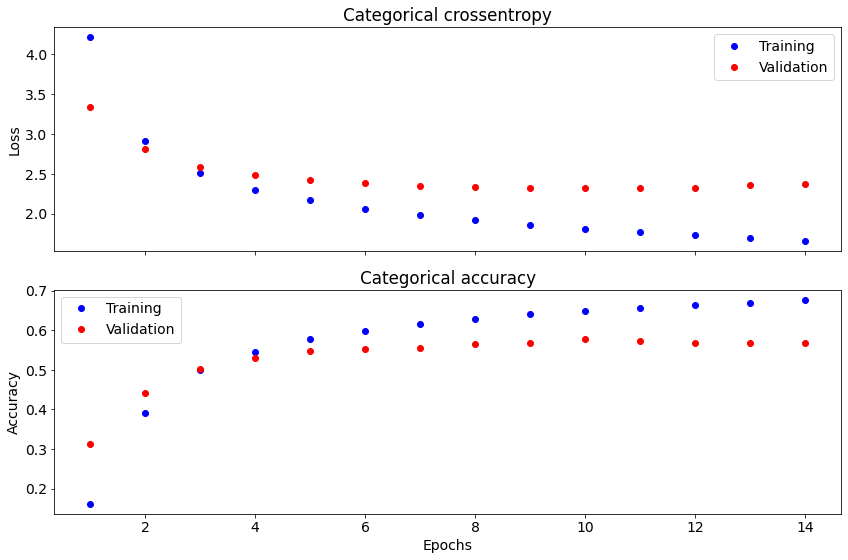

In [ ]:
# Train the model on original images only
model = train_model(model, train_ds, valid_ds)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               58112     
                                                                 
 dense_5 (Dense)             (None, 256)               65792     
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 107)               13803     
                                                                 
Total params: 170,603
Trainable params: 170,603
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
301/301 - 1s - loss: 3.5656 - sparse_categorical_accuracy: 0.2732 - val_loss: 2.7492 - val_sparse_categorical_accuracy: 0.4273 - 1s/epoch - 5ms/step
Epoch 2/100
301/301

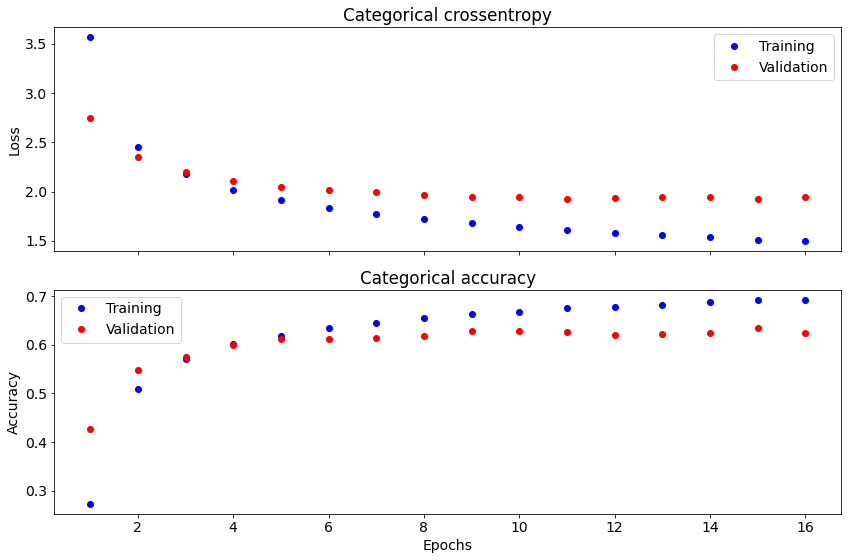

In [ ]:
# Train other model on the original and flipped images
model_fl = get_model(
    n_features=n_features,
    n_classes=107,
    dense_neurons=[256, 256, 128]
)

model_fl = train_model(model_fl, train_ds_fl, valid_ds_fl)